# Building Damage Assessment from High-resolutoin Remote Sensing Images

In this project, I tested several machine learning methods on classifying fire-induced building damages from high-resolution remote sensing images and analyzed important features related to the predictions. Specifically, I used annotations of fire-related damages from the xView 2 Building Damage Assessment dataset and trained the classification model on high resolution NAIP remote sensing images (0.6 meter resolution with RGB and NIR bands) of corresponding fire events.
<br>Main Pipeline:
<br>**Data Preprocessing**: As both XView building annotations and NAIP images include geograohic information, XView data was converted to shapefiles to filter out corresponding NAIP images in the same location through GEE API. Both pre-fire and post-fire images were used. 
<br>**Feature Calculation:** Based on the four channels of NAIP images, features were further calculated through band math, convolutoinal filters and unsupervised methods. 
<br>**Classification Model:** Decision tree, SVM, random forest, xgboost, and simple neural networks were built to test their predictability of buliding damage types. The dicision tree, SVM, and random forest were run directly on the server provided by GEE API. XGBoost and neural net were run locally on images extracted through GEE from Google Colab. Feature effects on predictions were also evaluated (detailed analysis based on XGBoost results)

## Table of Content
(1) __Preprocessing XView Data__ (See *xview_preprocessing.py*): extract geographic coordinates and fire-related annotations as geojson and shapefilesfrom XView json files
<br>(2) __Set up__: Load API and packages. Connect to Google Drive, GEE API, and load annotations
<br>(3) __Visualize Dataset__: use GEE API and leaflet to visualize ground truth labels and acquire NAIP images based on the locations of these labels
<br>(4) __Features Calculation__: calculate several useful features for classification, including remote sensing indices, texture metrics, and some layers filtered by convolutional filters
<br>(5) __Unsupervised Clustering Features__: use some unsupervised methods to get clusters, superpixels, or segmentations as features; summarize characteristics of unsupervised features 
<br>(6) __Image Extraction__: using the extent of buildings with the same image id as the boundary to extract NAIP images from the GEE API. Exported images were saved on Google Drive
<br>(7) __Supervised Classification (server-end)__: GEE provide some fuctions for machine learning method (*Decision Tree, SVM, and Random Forest*) to do the classification directly on its server. Test these methods on the NAIP images and summarize their results
<br>(8) __Supervised Classificatoin (client-end, XGBoost)__: See notebook *BuildingProj_XGBoost*. Based on images extracted from (6), tune and train XGboost models locally on Google Colab for classification. Analysis features to quantify effects of important features on building damage prediction
<br>(9) __Supervised Classification (client-end, Simple Neural Network)__: See notebook *BuildingProj_NN*. Based on images extracted from (6), tune and train 5-layer neural network locally on Google Colab for classification.


## Setting Up

In this section, connect to the Google drive and read pre-processed bounding boxes for buildings

### Connect to Drive & Set Directory

In [0]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd "/content/drive/My Drive/FinalProj"
%ls "./Data/FireDataset/train"

### Load Data

In [0]:
# install dependencies and packages 
! pip install geopandas

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 18.0MB/s 
     |████████████████████████████████| 14.7MB 309kB/s 


In [0]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [0]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext) and not names.startswith("._"):
              file_list.append(path  +"/" + names)
  return(file_list)

In [0]:
# access training dataset (i.e. geojson, shpfiles)
# traingeo_path = "./Data/FireDataset/train_geo"
# gjsn_files = lstFiles(traingeo_path, '.geojson')
# shp_files = lstFiles(traingeo_path, '.shp')

In [0]:
merged_path = "./Data/FireDataset/merged_shp"
merged_files = lstFiles(merged_path, '.shp')

train_shp = merged_files[0]
test_shp = merged_files[1]

<BarContainer object of 5 artists>

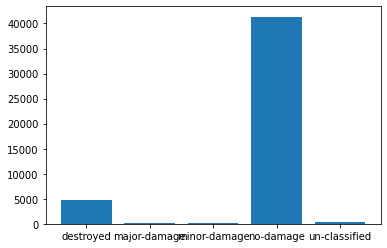

In [0]:
#get ground truth labels and check sample distributions
gdf = gpd.read_file(merged_files[0])
plt.bar(x=gdf.groupby('damage').count().index,height=gdf.groupby('damage').count()['ID'])

In [0]:
#convert categorical labels to int
#gdf['dmg_code']=0
#for value in gdf.damage.unique():
#    if value=='no-damage':
#        gdf.loc[gdf['damage']==value,'dmg_code']=1
#    elif value=='minor-damage':
#        gdf.loc[gdf['damage']==value,'dmg_code']=2
#    elif value=='major-damage':
#        gdf.loc[gdf['damage']==value,'dmg_code']=3
#    elif value=='destroyed':
#        gdf.loc[gdf['damage']==value,'dmg_code']=4
#    else:
#        gdf.loc[gdf['damage']==value,'dmg_code']=0

### Connect to GEE API & Load Asset

In [0]:
# initialize and connect to GEE 
from google.colab import auth
auth.authenticate_user()
!earthengine authenticate
import ee 
ee.Initialize()

Instructions for updating:
non-resource variables are not supported in the long term
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=2rB74OKTljNArsPh5ozl8kgsFpWxaYzLJ2VHxqtgJtc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/0gFZ8NgMmSu7gmVPIlhvmvLSu_SrLlDsjizX6HvsDl1vhEiJolVmqvg

Successfully saved authorization token.


In [0]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

geemap package not installed. Installing ...


In [0]:
# Connect to google cloud 
#! gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&code_challenge=JwelvS_s5LnRuTB_LNs7oTLmWhf2lfFX_k3iYNhbBdM&code_challenge_method=S256&access_type=offline&response_type=code&prompt=select_account


Enter verification code: 4/0gGV2Ijf5m64FLmSlzywQ29N_WQjlh0hDbWuZq2rDwP7Rfcg4GvICXg

You are now logged in as [yuhhuang@ucdavis.edu].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [0]:
# import feature collection asset 
train_data = ee.FeatureCollection('users/yuhhuang/BuildingExtraction/XView_training')
test_data = ee.FeatureCollection('users/yuhhuang/BuildingExtraction/XView_testing')

## Visualize Datasets
Interactively visualization using GEE API & leaflet

### Building Geometry and Attributes

Note: one building might be shown as no-damage and destroyed at the same time on map as both pre- and post- fire labels were included

In [0]:
def visualizeByAttribute(fc, className): 
  '''
  visualize building polygon based on damage type 'class' (0,1) 
  '''   
  empty = ee.Image().byte()
  feature = empty.paint(**{
    'featureCollection': fc,
    'color': className,
    'width': 1
  })
  return feature

train_palette = ['black', # unclassified/Non-building (0)
                 'blue', # no-damage (1)
                 'green', # minor-damage(2)
                 'yellow', # major-damage (3)
                 'red' # destryoed (4)
                 ]
# test_palette = ['yellow', # no-damage(0)
#                'blue' # destroyed (1) 
#                ]

Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=16)
Map.addLayer(visualizeByAttribute(train_data, 'dmg_code'), {'palette': train_palette, 'min': 0, 'max':4}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'dmg_code'), {'palette': train_palette,'min': 0, 'max':4}, 'test')
Map.addLayerControl()
Map

### Load NAIP Imagery
- Get the geographic coordinates of polygons from local geo-dataframe variable
- Convert geographic extent to GEE format boundary
- filter NAIP images from the database from the converted boundary

In [0]:
def extract_coords(geom):
    '''
    takes one polygon from geopandas and converts it to the GEE geometry format
    input: geom from each row of the 'geometry' column in the gpd dataframe 
    output: coordinate list of the GEE geometry
    '''
    try:
        coords=geom.__geo_interface__['coordinates']
        geom_extr=[list(map(list,coord)) for coord in coords]
        return geom_extr
    except:
        pass

def get_bounds(gdf):
    '''
    takes a geo data frame get convert its bounding extent to a GEE format rectangle
    '''
    bounds=gdf.total_bounds
    geom_bound=[[ [bounds[0],bounds[1]], [bounds[2],bounds[1]], [bounds[2],bounds[3]], [bounds[0],bounds[3]]]]
    return geom_bound

In [0]:
#filter data by site (2 fire locations)
gdf = gpd.read_file(train_shp)
santaRosa = gdf[(gdf['location_n'] == 'santa-rosa-wildfire') ] 
socal = gdf[(gdf['location_n'] == 'socal-fire')]

#get image bound for each site
SR_bounds=get_bounds(santaRosa)
SC_bounds=get_bounds(socal)

In [0]:
#convert each building polygon to GEE format feature
sr_geom=[extract_coords(pol) for pol in santaRosa['geometry']]
SR_ROI = ee.Geometry.MultiPolygon(sr_geom)
SR_Bound_Box=ee.Geometry.Polygon(SR_bounds)

sc_geom=[extract_coords(pol) for pol in socal['geometry']]
SC_ROI = ee.Geometry.MultiPolygon(sc_geom)
SC_Bound_Box=ee.Geometry.Polygon(SC_bounds)

In [0]:
# combine the bounding boxes from above into feature collection
features = [
  ee.Feature(SC_Bound_Box),
  ee.Feature(SR_Bound_Box)
]

finalBounds = ee.FeatureCollection(features);

In [0]:
#get pre- and post- fire images by geographic polygons
preFire = ee.Image(ee.ImageCollection('USDA/NAIP/DOQQ')
                  .filter(ee.Filter.date('2014-01-01', '2015-12-31'))
                  .select(['R', 'G', 'B', 'N'])
                  .filterBounds(finalBounds)
                  .mosaic());
                  
postFire = ee.Image(ee.ImageCollection('USDA/NAIP/DOQQ')
                  .filter(ee.Filter.date('2017-01-01', '2019-12-31'))
                  .select(['R', 'G', 'B', 'N'])
                  .filterBounds(finalBounds)
                  .mosaic());

preFire = preFire.clip(finalBounds)
postFire = postFire.clip(finalBounds)

trueColorVis = {
  min: 0.0,
  max: 255.0,
}

In [0]:
# visualize santa rosa building dataset overlaid on NAIP
Map = emap.Map(center=[38.4815,-122.7084], zoom=11)
Map.add_basemap('TERRAIN')
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'PreFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'Postfire')
Map.addLayer(finalBounds, {'color': 'white'}, 'bound', True, opacity=0.4)
Map.addLayer(visualizeByAttribute(train_data, 'dmg_code'), {'palette': train_palette, 'min': 0, 'max':4}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'dmg_code'), {'palette': train_palette,'min': 0, 'max':4}, 'test')
Map.addLayerControl()
Map

In [0]:
# visualize socal building dataset overlaid on NAIP
Map = emap.Map(center=[34.0922,-118.8058], zoom=11)
Map.add_basemap('TERRAIN')
Map.addLayer(preFire, trueColorVis, 'PreFire');
Map.addLayer(postFire, trueColorVis, 'Postfire');
Map.addLayer(finalBounds, {'color': 'white'}, 'Postfire', True, opacity = 0.8);
Map.addLayer(visualizeByAttribute(train_data, 'dmg_code'), {'palette': train_palette, 'min': 0, 'max':4}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'dmg_code'), {'palette': train_palette,'min': 0, 'max':4}, 'test')
Map.addLayerControl()
Map

## Feature Calculation

__Remote Sensing Indices:__

NDVI: (NIR-R)/(NIR+R)

Bare Soil Index: (R+B-G)/(R+G+B)

Shadow Index: $\sqrt {(256-B)*(256-G)}$

__Texture Information:__

 GLCM and spatial association of neighborhood

__Convolutional Filters:__

Canny edge detection, shape-sensitive filters, and some other convolutional filters

###NDVI

In [0]:
def getNDVI(image):
  '''
  Add Normalized Differenced Vegetation Index using NIR and Red bands
  '''
  nir = image.select('N')
  red = image.select('R')
  ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
  new_image = image.addBands(ndvi)
  return new_image

preFire = getNDVI(preFire)
postFire = getNDVI(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI']


### Edge Detection
to extract structural information from different vision objects and dramatically reduce the amount of data to be processed.

In [0]:
def edgeDetection(image, band):
  '''
  Perform Canny edge detection and add to image.
  '''
  canny = ee.Algorithms.CannyEdgeDetector(**{
    'image': image.select(band), 'threshold': 50, 'sigma': 1
  })
  new_image = image.addBands(canny.rename('edge'))
  return new_image


preFire = edgeDetection(preFire, 'R')
postFire = edgeDetection(postFire, 'R')
print(preFire.bandNames().getInfo())


['R', 'G', 'B', 'N', 'NDVI', 'edge']


### Bare Soil Index (BSI)

In [0]:
def bareSoil(image):
  '''
  Add Bare Soil Index Index using the Red, Blue, and Green bands
  '''
  red = image.select('R')
  blue = image.select('B')
  green = image.select('G')
  BSI = red.add(blue).subtract(green).divide(red.add(blue).add(green)).rename('BSI')
  new_image = image.addBands(BSI)
  return new_image

preFire = bareSoil(preFire)
postFire = bareSoil(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI']


### Shadow Index

In [0]:
def shadowIndex(image):
  '''
  Add Shadow Index using Blue and Green bands
  '''
  SI = image.expression(
      'sqrt((2.56 - B) * (2.56 - G))', {
        'B': image.select('B'),
        'G': image.select('G')
  }).rename('SI');
  new_image = image.addBands(SI)
  return new_image

preFire = shadowIndex(preFire)
postFire = shadowIndex(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI']


### Texture
1) measure spatial association of neighborhood
2) calculate gray-level co-occurrence matrix (GLCM)


GLCM Texture list (selection in bold):
- Angular Second Moment: # of repeated pairs
- **Contrast**: local contrast 
- **Correlation**: correlation between pairs of pixels 
- **Variance**: spreat-out of the Grayscale 
-**Inverse Difference Moment**: homogeneity
- sum average
- sum variance
- sum entropy
- entropy: randomness of the grayscale
- difference variance
- difference entropy
- information measure of correlation 1, 2 , and Max Corr. Coefficient.
- **dissimilarity**
- inertia
- **cluster shade**
- cluster prominence

In [0]:
import math

def association(image):
  ''' 
  Get association values with NIR band. 
  (1) compute entropy w. defined neighborhood
  (2) local Geary's C, measure of spatial association
  '''
  # Get the NIR band.
  nir = image.select('N')
  # Define a neighborhood with a kernel.
  square = ee.Kernel.square(**{'radius': 4})
  # Compute entropy and display.
  entropy = nir.entropy(square)
  # Create a list of weights for a 9x9 kernel.
  list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
  # The center of the kernel is zero.
  centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
  # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
  lists = [list, list, list, list, centerList, list, list, list, list]
  # Create the kernel from the weights.
  # Non-zero weights represent the spatial neighborhood.
  kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)

  # Convert the neighborhood into multiple bands.
  neighs = nir.neighborhoodToBands(kernel)

  # Compute local Geary's C, a measure of spatial association.
  gearys = nir.subtract(neighs).pow(2).reduce(ee.Reducer.sum()) \
             .divide(math.pow(9, 2)).rename('texture');
  new_image = image.addBands(gearys)
  return new_image


def glcm_texture(image):
    '''
    calculate GLCM for each spectral band (contrast and variance only for NIR and Red band)
    '''
    #average all the directional bands
    #consider a neighborhood of 4 pixels
    texture_img=image.select(['R','G','B','N']).glcmTexture(size=4,average=True)
    #select some useful textures :
    selection=['R_contrast','N_contrast','R_corr','G_corr','B_corr','N_corr','R_var','N_var',
               'R_idm','G_idm','B_idm','N_idm','R_diss','N_diss','R_shade','G_shade','B_shade','N_shade']
    new_image = image.addBands(texture_img.select(selection))
    return new_image

preFire = association(preFire)
preFire = glcm_texture(preFire)
postFire = association(postFire)
postFire = glcm_texture(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade']


### Other selected convolutional filters 
(tuned with best visual performance)
- low-pass convolutional filter (Gaussian)
- high-pass filter and gradient (has been represented by canny edge detection above)
- shape-sensitive filter (rectangle, octagon)
- manhattan kernel based on rectilinear (city-block) distance

In [0]:
def conv_filter(image):
    '''
    apply gaussian, octagon, and mangattan convolutional filters to the image
    '''
    #define filters
    #Gaussian
    gauss=ee.Kernel.gaussian(radius=7, sigma=2, units='pixels', normalize=True)
    # #define a 19 by 11 rectangle low pass filter
    # low_pass_rect1 = ee.Kernel.rectangle(xRadius=9,yRadius=5, units='pixels', normalize=True);
    # #the opposite way
    # low_pass_rect2 = ee.Kernel.rectangle(xRadius=5,yRadius=9, units='pixels', normalize=True);
    #octagon
    low_oct = ee.Kernel.octagon(radius=5, units='pixels', normalize=True);
    #manhattan
    manha=ee.Kernel.manhattan(radius=4, units='pixels', normalize=True)
    new_image=image
    filt_dict={'gauss':gauss,'low_oct':low_oct,'manha':manha}
    for name,filt in filt_dict.items():
        smooth=image.select(['R','G','B','N']).convolve(filt).rename(['R_'+name,'G_'+name,'B_'+name,'N_'+name])
        new_image = new_image.addBands(smooth)
    return new_image

preFire = conv_filter(preFire)
postFire = conv_filter(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha']


### Visualize Some Features

In [0]:
siViz = {'min': 0, 'max': 100, 'palette': ['ffff00', '330033']}
bsiViz = {'min': 0.0, 'max': 0.3, 'palette': ['7fffd4', 'b99879']}
ndviViz = {'min': -0.5, 'max': 0.5, 'palette': ['cc8e7f', '268b07']}
texViz = {'min': 0, 'max': 4000, 'palette': ['fe6b73', '7fffd4']}

Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=16)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(preFire.select(['NDVI']),ndviViz, 'NDVI')
Map.addLayer(preFire.select(['SI']),siViz, 'SI')
Map.addLayer(preFire.select(['edge']),'', 'Canny')
Map.addLayer(preFire.select(['BSI']),bsiViz, 'BSI')
Map.addLayer(preFire.select(['texture']),texViz, 'texture')
Map.addLayer(postFire.select('B_corr'), {'palette': ['cc8e7f', '268b07']}, 'corB')
Map.addLayer(postFire.select('R_corr'), {'palette': ['cc8e7f', '268b07']}, 'corR')
Map.addLayer(postFire.select('G_shade'), {'palette': ['cc8e7f', '268b07']}, 'shadeG')
Map.addLayer(postFire.select('N_shade'), {'palette': ['cc8e7f', '268b07']}, 'shadeN')
Map.addLayer(train_data, {'color': 'yellow'}, 'training')
Map.addLayer(test_data, {'color': 'blue'}, 'testing')
Map.addLayerControl()
Map

## Unsupervised Clustering Features

### KMeans Clustering

In [0]:
# Make the training dataset.
training = postFire.sample(**{
  'region': finalBounds,
  'scale': 10,
  'numPixels': 5000
})

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(15).train(training)

# Cluster the input using the trained clusterer.
preFire_result = preFire.cluster(clusterer).rename('KMeans')
postFire_result = postFire.cluster(clusterer).rename('KMeans')

In [0]:
# add KMeans clustering 
postFire = postFire.addBands(postFire_result)
preFire = preFire.addBands(preFire_result)
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'KMeans']


In [0]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=19)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_result.randomVisualizer(),'', 'postFire_Kmeans',opacity=0.6)
Map.addLayer(preFire_result.randomVisualizer(),'', 'preFire_Kmeans', opacity=0.6)
Map.addLayer(train_data, {'color': 'yellow'}, 'training',opacity=0.4)
Map.addLayer(test_data, {'color': 'blue'}, 'testing',opacity=0.4)
Map.addLayerControl()
Map

__Feature Description__
<br> Buildings seem to be assigned as the same clusters from a simple k-means clustering method. For postfire clusters, there are also showing the tendencying of classifying one building into several several different components, possibly due to the partial damage from the postfire image.

###Learning Vector Quantization (LVQ) Clustering

In [0]:
# Make the training dataset.
training = postFire.select(['R','G','B','N','NDVI','BSI','SI','edge','texture']).sample(**{
  'region': finalBounds,
  'scale': 10,
  'numPixels': 5000
})

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaLVQ(15).train(training)

# Cluster the input using the trained clusterer.
preFire_result = preFire.select(['R','G','B','N','NDVI','BSI','SI','edge','texture']).cluster(clusterer).rename('LVQ')
postFire_result = postFire.select(['R','G','B','N','NDVI','BSI','SI','edge','texture']).cluster(clusterer).rename('LVQ')

In [0]:
# add layer
postFire = postFire.addBands(postFire_result)
preFire = preFire.addBands(preFire_result)
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'KMeans', 'KMeans_Seg', 'SNIC', 'LVQ']


In [0]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=18)
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_result.randomVisualizer(),'', 'postFire_LVQ',opacity=0.6)
Map.addLayer(preFire_result.randomVisualizer(),'', 'preFire_LVQ', opacity=0.6)
#Map.addLayer(train_data, {'color': 'yellow'}, 'training',opacity=0.4)
#Map.addLayer(test_data, {'color': 'blue'}, 'testing',opacity=0.4)
Map.addLayer(visualizeByAttribute(train_data, 'dmg_code'), {'palette': train_palette, 'min': 0, 'max':4}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'dmg_code'), {'palette': train_palette,'min': 0, 'max':4}, 'test')
Map.addLayerControl()
Map

__Feature Description__
<br>For LVQ, it seems mainly grouping those non-building areas into different clusters. Although in this way, some building can be easily identified, it has a large problem of combining building, road, and all other impervious surfaces together as one large cluster

###  KMeans Segmentation

Performs K-Means clustering on the input image. Outputs a 1-band image containing the ID of the cluster that each pixel belongs to.



In [0]:
pre_kmeans = ee.Algorithms.Image.Segmentation.KMeans(preFire, 15, 1000, 20, 0, False, False)
pre_clusters = pre_kmeans.select('clusters').rename('KMeans_Seg')

post_kmeans = ee.Algorithms.Image.Segmentation.KMeans(postFire, 15, 1000, 20,0, False, False)
post_clusters = post_kmeans.select('clusters').rename('KMeans_Seg')

In [0]:
# add layer
postFire = postFire.addBands(post_clusters)
preFire = preFire.addBands(pre_clusters)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'KMeans', 'LVQ', 'KMeans_Seg']


In [0]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=18)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(pre_clusters.randomVisualizer(),'', 'pre_clusters', opacity=0.6)
Map.addLayer(post_clusters.randomVisualizer(),'', 'post_clusters', opacity=0.6)
Map.addLayer(train_data, {'color': 'yellow'}, 'training',opacity=0.4)
Map.addLayer(test_data, {'color': 'blue'}, 'testing',opacity=0.4)
Map.addLayerControl()
Map

### Simple Non-Iterative Clustering (SNIC) Segmentation

An improved version of non-parametric SLIC. Superpixel clustering based on SNIC (Simple Non-Iterative Clustering). Outputs a band of cluster IDs and the per-cluster averages for each of the input bands.




In [0]:
def expandSeeds(seeds): 
  seeds = seeds.unmask(0).focal_max()
  return seeds.updateMask(seeds)

In [0]:
seeds = ee.Algorithms.Image.Segmentation.seedGrid(30)

pre_snic = ee.Algorithms.Image.Segmentation.SNIC(preFire, 30, 15, 8, 200, seeds).select(["R_mean", "G_mean", "B_mean", "N_mean", "clusters"], ["R", "G", "B", "N", "clusters"])
pre_clusters = pre_snic.select('clusters').rename('SNIC')

post_snic = ee.Algorithms.Image.Segmentation.SNIC(postFire, 30, 15, 8)
post_clusters = post_snic.select('clusters').rename('SNIC')

In [0]:
# add layer
postFire = postFire.addBands(post_clusters)
preFire = preFire.addBands(pre_clusters)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'KMeans', 'LVQ', 'KMeans_Seg', 'SNIC']


In [0]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=18)
Map.addLayer(pre_clusters.randomVisualizer(),'' , "clusters")
Map.addLayer(post_clusters.randomVisualizer(),'', 'postFire_SNIC', opacity=0.6)
Map.addLayer(expandSeeds(seeds), {}, 'seeds')
Map.addLayer(train_data, {'color': 'yellow'}, 'training',opacity=0.4)
Map.addLayer(test_data, {'color': 'blue'}, 'testing',opacity=0.4)
Map.addLayerControl()
Map

__Feature Description__
<br>This superpixel method is segmented the images quite well. There is a obvious difference between pre- and post- results, with post segmentations being more scattered 

## Image Extraction

To run xgboost and neural networks locally, extract images by building polygons from the GEE API. Extracted images (with all features) will be saved in Google Drive. Reading these extracted images as well as training XGBoost and Neural Net will be run in seperate jupyter notebooks.
<br>__output images will have all 43 features at a resolutoin of 1 meter__

<br>__To reduce image size (due to the expot limit from GEE API):__
<br>**Each polygon converted from XView annotations has recorded its original image ID. Based on these, for each id, clip the pre- and post- images respectively by polygons with the same id**
<br>**The output image would roughly be in the same extent as its original image**

In [0]:
#make sure all features (each band of the image has the same data type)
preFire=ee.Image.float(preFire) 
postFire=ee.Image.float(postFire) 

In [0]:
#The whole pre- and post- images include two seperate areas, first use geo dataframe to subset Santa Rosa
#Santa Rosa
train_data_SR=train_data.filter(ee.Filter.eq('location_n', 'santa-rosa-wildfire'))
santaRosa = gdf.query("location_n == 'santa-rosa-wildfire'")
ID_list=santaRosa.ID.unique()
#convert ground truth polygons to image
SR_true_pre = ee.Image.byte(train_data_SR.filter(ee.Filter.eq('pre_post_d','pre')).reduceToImage(properties=['dmg_code'],reducer=ee.Reducer.first()))
SR_true_post = ee.Image.byte(train_data_SR.filter(ee.Filter.eq('pre_post_d','post')).reduceToImage(properties=['dmg_code'],reducer=ee.Reducer.first()))

In [0]:
#use the export function from GEE API to save both pre- and post-fire features and ground truth images
for index in ID_list:
    try:
        image_ROI=train_data_SR.filter(ee.Filter.eq('ID', index))
        #post
        ROI_shp=santaRosa[(santaRosa['ID']==index)&(santaRosa['pre_post_d']=='post')]
        image_bound=ee.Geometry.Polygon(get_bounds(ROI_shp))
        task1=ee.batch.Export.image.toDrive(image=postFire, description='post_'+index, folder='NAIP_img_new', region=image_bound, scale=1)
        task2=ee.batch.Export.image.toDrive(image=SR_true_post, description='post_'+index+'gt', folder='NAIP_img_new', region=image_bound, scale=1)
        task1.start()
        task2.start()
        #print(task2.status())
        #pre
        ROI_shp=santaRosa[(santaRosa['ID']==index)&(santaRosa['pre_post_d']=='pre')]
        image_bound=ee.Geometry.Polygon(get_bounds(ROI_shp))
        task3=ee.batch.Export.image.toDrive(image=preFire, description='pre_'+index, folder='NAIP_img_new', region=image_bound, scale=1)
        task4=ee.batch.Export.image.toDrive(image=SR_true_pre, description='pre_'+index+'gt', folder='NAIP_img_new', region=image_bound, scale=1)
        task3.start()
        task4.start()
        #print(task3.status())
        #if index=='00000376':
        #    print('done!')
    except:
        continue


## Supervised Classification




Filter Imagery
<br>To run machine learning models on GEE, first need to reduce data amount due to its restrictions
<br>Exclude areas with vegetation below i.e. only keeps imagery areas with urban and baresoil 
<br>Note: this mask was not applied to the exported images used for XGBoost and neural net 

In [0]:
hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')

def applyMask(imageryA, imageryB, hansenImage):
  '''
  Mask out all vegetation and water from imagery from pre disaster values.
  '''
  NDVIMaskB = imageryB.select('NDVI').lt(0.005)
  dataMask =  hansenImage.select('datamask')
  waterMask = dataMask.eq(1)
  imageryA = imageryA.updateMask(NDVIMaskB)
  new_imagery = imageryA.updateMask(waterMask)
  return new_imagery

postFire_filt = applyMask(postFire, preFire, hansenImage)

In [0]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=11)
Map.addLayer(postFire_filt.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayerControl()
Map

### Train Data

In [0]:
print(postFire_filt.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'KMeans', 'KMeans_Seg', 'SNIC', 'LVQ']


In [0]:
#bands = ['R', 'G', 'B', 'N', 'NDVI'] #'edge', 'BSI', 'SI', 'texture', 'KMeans', 'LVQ', 'KMeans_Seg', 'SNIC'
bands=postFire_filt.bandNames().getInfo()
training = postFire_filt.select(bands).sampleRegions(**{
  'collection': train_data,
  'properties': ['dmg_code'],
  'scale': 30
});

### Decision Tree

#### Classifier

In [0]:
# Train a CART classifier with default parameters.
classifier = ee.Classifier.smileCart().train(training, 'dmg_code', bands);

# Classify the image with the same bands used for training.
postFire_classified = postFire_filt.select(bands).classify(classifier);
#preFire_classified = preFire_filt.select(bands).classify(trained);

#### Feature Importance

In [0]:
class_explain = classifier.explain()
variable_importance = ee.Feature(None, ee.Dictionary(class_explain).get('importance'))
variable_importance.getInfo()

{'geometry': None,
 'properties': {'B': 0.02194288854150557,
  'BSI': 0,
  'B_corr': 0,
  'B_gauss': 0.009158680555555541,
  'B_idm': 0.01755926111230438,
  'B_low_oct': 0.004458551767260323,
  'B_manha': 0,
  'B_shade': 0.0816197338504763,
  'G': 0,
  'G_corr': 0,
  'G_gauss': 0.012331526360544163,
  'G_idm': 0,
  'G_low_oct': 0,
  'G_manha': 0.08418367346938771,
  'G_shade': 0,
  'KMeans': 0,
  'KMeans_Seg': 6.938893903907228e-18,
  'LVQ': 0,
  'N': 0,
  'NDVI': 0.12499999999999964,
  'N_contrast': 0.01007275813196429,
  'N_corr': 0.05578512396694213,
  'N_diss': 0,
  'N_gauss': 0.03994170561124387,
  'N_idm': 0.09374999999999997,
  'N_low_oct': 1.734723475976807e-18,
  'N_manha': 0,
  'N_shade': 0,
  'N_var': 0,
  'R': 0.2781038456988883,
  'R_contrast': 0.1020408163265306,
  'R_corr': 0,
  'R_diss': -1.3877787807814457e-17,
  'R_gauss': 0.017897702507311986,
  'R_idm': 1.3877787807814457e-17,
  'R_low_oct': 0.028491512345679024,
  'R_manha': 3.469446951953614e-18,
  'R_shade': 0.05

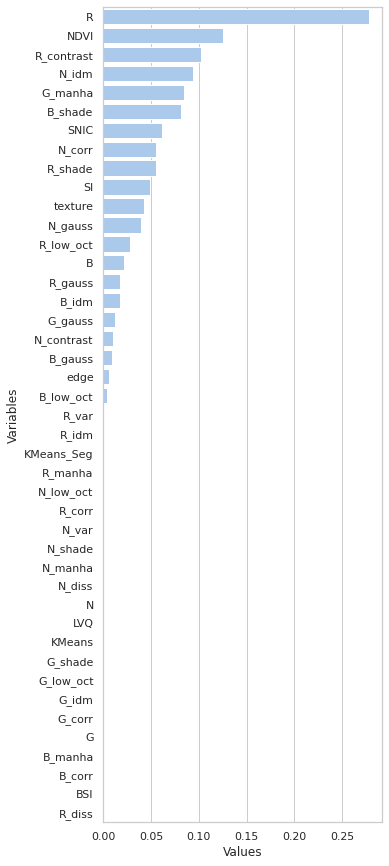

In [0]:
import json
import matplotlib.pylab as plt
import seaborn as sns 
import pandas.util.testing as tm
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

var_dict = variable_importance.getInfo()

lists = sorted(var_dict['properties'].items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
var = [i[0] for i in lists]
values = [i[1] for i in lists]
d = pd.DataFrame({'Variables':var,'Values':values})


plt.figure(figsize=(5,15))
sns.barplot('Values', 'Variables', data = d, label="Variables", color="b")
plt.savefig("Model_Fig/CART_feature_imp.png", dpi=250)

####Validation

In [0]:
validation = postFire_classified.sampleRegions(**{
  'collection': test_data,
  'properties': ['dmg_code'],
  'scale': 30,
})

testAccuracy = validation.errorMatrix('dmg_code', 'classification');

In [0]:
print("Test Accuracy: ", testAccuracy.accuracy().getInfo())
print("Kappa Accuracy: ", testAccuracy.kappa().getInfo())
print("Producer Accuracy: ", testAccuracy.producersAccuracy().getInfo())
print("User Accuracy(): ", testAccuracy.consumersAccuracy().getInfo())

Test Accuracy:  0.8672817601135557
Kappa Accuracy:  -0.0014138519484173577
Producer Accuracy:  [[0], [0.9983660130718954], [0], [0], [0]]
User Accuracy():  [[0, 0.8685145700071073, 0, 0, 0]]


#### Classification Visual

In [0]:
class_palette = ['bff7ff','ff9900']

Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=11)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_classified,
             {'palette': train_palette, 'min': 0, 'max':4},
             'postFire_classification')
Map.addLayer(visualizeByAttribute(train_data, 'dmg_code'), {'palette': train_palette, 'min': 0, 'max':4}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'dmg_code'), {'palette': train_palette,'min': 0, 'max':4}, 'test')
Map.addLayerControl()
Map

__Summarization of Decision Tree Classification Results__
<br> The overall accuracy was 86.72% but decision tree classifier cannot be considered as a good classifier as there is negative Cohen's Kappa coefficient, implying bad agreement of ground truth and predictions. Possibly due to the imbalance distribution of different damage samples, the user's accuracy (1-commision error) and producer's accuracy (1-omission error) are only high for no-damage buildings. The spatial map also showed a bad classification with almost all buildings labeled as no-damage for both of the two fires. 
<br>Further modification of the method can be focus on grouping building types into 3 types: non-building, no-damage, and destroyed. 
<br> Feature importance showed that only around half of the variables can be considered as important features and were used for decision tree classifier. Red band reflection is a dominated feature determining the predicition accuracy. Other important features were mostly texture bands for RGBN bands and some vegetation indicies such as normalized difference vegetation index and shadow index.


### Support Vector Machine


#### Classifier

In [0]:
# Create an SVM classifier with custom parameters.
classifier = ee.Classifier.libsvm(**{
  'kernelType': 'RBF'
}).train(training, 'dmg_code', bands)

# Classify the image.
postFire_classified = postFire_filt.select(bands).classify(classifier)

#### Validation

In [0]:
validation = postFire_classified.sampleRegions(**{
  'collection': test_data,
  'properties': ['dmg_code'],
  'scale': 30,
})

testAccuracy = validation.errorMatrix('dmg_code', 'classification');

In [0]:
print("Test Accuracy: ", testAccuracy.accuracy().getInfo())
print("Kappa Accuracy: ", testAccuracy.kappa().getInfo())
print("Producer Accuracy: ", testAccuracy.producersAccuracy().getInfo())
print("Consumers Accuracy(): ", testAccuracy.consumersAccuracy().getInfo())

Test Accuracy:  0.8687012065294535
Kappa Accuracy:  0
Producer Accuracy:  [[0], [1], [0], [0], [0]]
Consumers Accuracy():  [[0, 0.8687012065294535, 0, 0, 0]]


#### Classification Visual

In [0]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=11)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_classified,
             {'palette': train_palette, 'min': 0, 'max':4},
             'postFire_classification')
Map.addLayer(visualizeByAttribute(train_data, 'dmg_code'), {'palette': train_palette, 'min': 0, 'max':4}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'dmg_code'), {'palette': train_palette,'min': 0, 'max':4}, 'test')
Map.addLayerControl()
Map

__Summarization of SVM Classification Results__
<br> SVM classifier obtained similar classification accuracy as random forest classifier (shown as below). Also, similar to the decision tree, as influenced by the distribution of sample amounts, the relatively high accuracy does not lead to a good classification as there is low Kappa and low accuracy for classes that are not no-damage

### Random Forest

ee.Classifier.randomForest(numberOfTrees, variablesPerSplit, minLeafPopulation, bagFraction, outOfBagMode, seed)


#### Classifier

In [0]:
# Create an SVM classifier with custom parameters.
classifier = ee.Classifier.smileRandomForest(**{
  'numberOfTrees': 100
}).train(training, 'dmg_code', bands)

postFire_classified = postFire_filt.select(bands).classify(classifier)

#### Feature Importance

In [0]:
class_explain = classifier.explain()
variable_importance = ee.Feature(None, ee.Dictionary(class_explain).get('importance'))
variable_importance.getInfo()

{'geometry': None,
 'properties': {'B': 70.67130027185189,
  'BSI': 73.77424030111477,
  'B_corr': 76.96757882312595,
  'B_gauss': 76.46573916887527,
  'B_idm': 81.33837813391081,
  'B_low_oct': 80.47469199780156,
  'B_manha': 71.2735040028588,
  'B_shade': 78.55580312015417,
  'G': 63.368624276928145,
  'G_corr': 73.39872816927638,
  'G_gauss': 65.58644001235618,
  'G_idm': 71.40275662052721,
  'G_low_oct': 65.33425680486809,
  'G_manha': 82.79302156350707,
  'G_shade': 75.81674136105336,
  'KMeans': 15.304898096456853,
  'KMeans_Seg': 30.199912164495938,
  'LVQ': 33.93049175929928,
  'N': 71.22886329120827,
  'NDVI': 74.23987416355511,
  'N_contrast': 67.82075023964398,
  'N_corr': 73.01259859000874,
  'N_diss': 74.34349020810741,
  'N_gauss': 85.58865462782549,
  'N_idm': 84.92579424122262,
  'N_low_oct': 77.38418706912024,
  'N_manha': 78.94231675293547,
  'N_shade': 72.35151939787688,
  'N_var': 75.59298216570824,
  'R': 69.70672784425446,
  'R_contrast': 66.64502834562734,
  'R_c

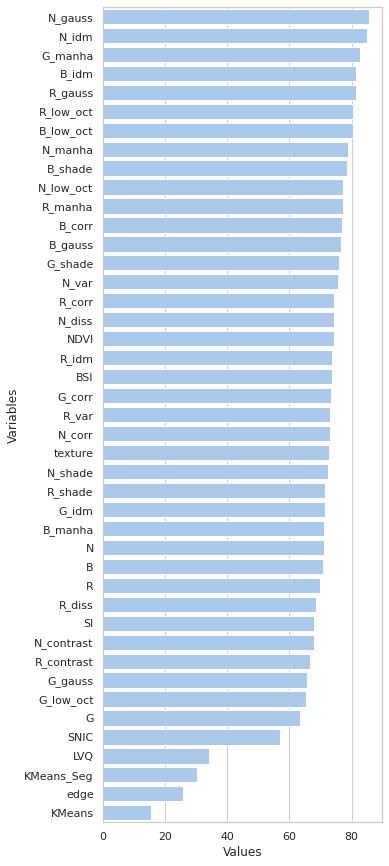

In [0]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

var_dict = variable_importance.getInfo()

lists = sorted(var_dict['properties'].items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
var = [i[0] for i in lists]
values = [i[1] for i in lists]
d = pd.DataFrame({'Variables':var,'Values':values})

plt.figure(figsize=(5,15))
sns.barplot('Values', 'Variables', data = d, label="Variables", color="b")
plt.savefig("Model_Fig/RF_feature_imp.png", dpi=250)

####Validation

In [0]:
validation = postFire_classified.sampleRegions(**{
  'collection': test_data,
  'properties': ['dmg_code'],
  'scale': 30,
})

testAccuracy = validation.errorMatrix('dmg_code', 'classification');

In [0]:
print("Test Accuracy: ", testAccuracy.accuracy().getInfo())
print("Kappa Accuracy: ", testAccuracy.kappa().getInfo())
print("Producer Accuracy: ", testAccuracy.producersAccuracy().getInfo())
print("Consumers Accuracy(): ", testAccuracy.consumersAccuracy().getInfo())

Test Accuracy:  0.8687012065294535
Kappa Accuracy:  0
Producer Accuracy:  [[0], [1], [0], [0], [0]]
Consumers Accuracy():  [[0, 0.8687012065294535, 0, 0, 0]]


#### Classification Visual

In [0]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=11)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_classified,
             {'palette': train_palette, 'min': 0, 'max':4},
             'postFire_classification')

Map.addLayer(visualizeByAttribute(train_data, 'dmg_code'), {'palette': train_palette, 'min': 0, 'max':4}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'dmg_code'), {'palette': train_palette,'min': 0, 'max':4}, 'test')
Map.addLayerControl()
Map

__Summarization of Random Forest Classification Results__
<br> Again, although the overall accuracy showed as 86.87%, the random forest classifier doesn't show a good classification result when evaluated by the spatial matching of the predictoins. The Cohen's Kappa index is almost 0 indicating a bad match between ground truth and classifications. The reason might be the imbalance distribution of samples as most of them have been dominated by no-damage. This has also been verified by the user's accuracy (1-commision error) and producer's accuracy (1-omission error), which are only high for the type of no-damage buildings. The map visualizaiton futher indicate a bad classification.
<br> As for features, the feature importance indicated that there was not a strong dominated feature determining the classification accuracy. However, it was still showing that the Gaussian filtered near infrared layer was the most important variable while some cluster layers such as kmeans segmentation, kmeans clusters, LVQ segmentations, and edge detection were among the least important variables.

## Next Step (**See XGBoost and NN Notebooks**)
As a preliminary examination of machine learning classifiers (decision tree, SVM, and random forest; trained on GEE server) doesn't show good spatial patterns and identifications of building damages even though they have overall accuracy around 85%, the next step is to test out some other methods (XGBoost and neural networks) that were normally found to have better results with some modifications of the original dataset. Please see the **XGBoost and NN notebooks** for the next step. The extracted NAIP data exported in this notebook will be used as output for these two methods and they will be ran at the local client-end with sklearn and tensorflow. A more detailed analysis of features will also be conducted in the **XGBoost notebook**.